On this Notebook, we will focus on balanced dataset for classification. Before, that let's experiment on unbalanced with duplicates removed


In [1]:
#library import
import pandas as pd # for data manipulation and analysis
import numpy as np # for scientific computing with Python
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
import seaborn as sns # for advanced visualization

Imported unbalanced dataset has had it's stopwords and punctuation removed

In [2]:
from collections import Counter

df= pd.read_csv('../Data/Preprocessed/unbal_word2vec.csv')
df_unbal_word2vec= df.copy()

# 70:30 split
from sklearn.model_selection import train_test_split

# Split into X and y
X = df_unbal_word2vec.drop('Target', axis=1)  # all columns except the 'Target' column
y = df_unbal_word2vec['Target']              # the 'Target' column

X_train_unbal, X_test_unbal, y_train_unbal, y_test_unbal= train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print(f'Train split Shape: {Counter(y_train_unbal)}')
print(f'Test split Shape: {Counter(y_test_unbal)}')


Train split Shape: Counter({1: 1086, 0: 721, 2: 200, 5: 127, 4: 86, 3: 67})
Test split Shape: Counter({1: 272, 0: 180, 2: 50, 5: 32, 4: 22, 3: 16})


In [3]:
y_train_unbal.count()


2287

In [4]:
y_test_unbal.count()

572

In [5]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_unbal), y=y_train_unbal)
class_weights_dict = dict(enumerate(class_weights))

# Training SVC

svc = SVC(probability=True, class_weight=class_weights_dict, random_state=42)
svc.fit(X_train_unbal,y_train_unbal)

SVC(class_weight={0: 0.5286638927415627, 1: 0.35098219766728056,
                  2: 1.9058333333333333, 3: 5.689054726368159,
                  4: 4.432170542635659, 5: 3.0013123359580054},
    probability=True, random_state=42)

In [7]:
# Function to evaluate model and returns target predictions 
def make_scores(model, features, target):
    model_pred = model.predict(features)

    print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(model_pred , target))) 

    roc_auc = metrics.roc_auc_score(target , model.predict_proba(features), multi_class='ovr')
    print('AUC : {0:0.5f}'.format(roc_auc))

    print('Precision : {0:0.5f}'.format(metrics.precision_score(target , model_pred, average='macro')))
    print('Recall : {0:0.5f}'.format(metrics.recall_score(target , model_pred, average='macro')))
    print('F1 : {0:0.5f}'.format(metrics.f1_score(target , model_pred, average='macro')))
    print(classification_report(target, model_pred))
    
    return model_pred

# Scores of SVC
svc_pred=make_scores(svc, X_test_unbal, y_test_unbal)

Accuracy :0.51923
AUC : 0.80683
Precision : 0.34580
Recall : 0.38447
F1 : 0.34793
              precision    recall  f1-score   support

           0       0.79      0.72      0.76       180
           1       0.69      0.47      0.56       272
           2       0.24      0.42      0.30        50
           3       0.04      0.06      0.05        16
           4       0.20      0.41      0.27        22
           5       0.11      0.22      0.15        32

    accuracy                           0.52       572
   macro avg       0.35      0.38      0.35       572
weighted avg       0.62      0.52      0.55       572



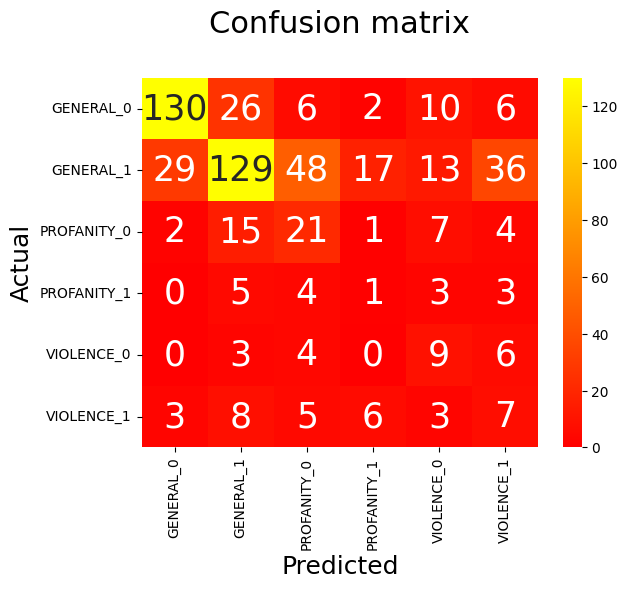

In [8]:
# Heatmap for Confusion Matrix
def make_confusion_matrix(target, prediction):
    cnf_matrix = metrics.confusion_matrix(target,prediction)
    cnf_matrix_df = pd.DataFrame(cnf_matrix,
                         index = ['GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'], 
                         columns = ['GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'])
    p = sns.heatmap(cnf_matrix_df, annot=True, annot_kws={"size": 25}, cmap="autumn" ,fmt='g')

    plt.title('Confusion matrix', y=1.1, fontsize = 22)
    plt.ylabel('Actual',fontsize = 18)
    plt.xlabel('Predicted',fontsize = 18)
    plt.show()

# Confusion Matrix for SVC
make_confusion_matrix(y_test_unbal,svc_pred)

## Let's Focus on Balancing
- We'll undersample general class, while oversampling minorities
- For undersampling, experiments are done on: NeighbourhoodCleaningRule(NCR) and CondensedNearestNeighbour(CNN)
- For oversampling, experiments are done on: Synthetic Minority Over-sampling Technique(SMOTE) and Adaptive Synthetic Sampling(ADASYN)

## NCR and SMOTE

check Create_embeddings to know target encodeding
- GENERAL_0: 0
- GENERAL_1: 1
- PROFANITY_0: 2
- PROFANITY_1: 3
- VIOLENCE_0: 4
- VIOLENCE_1: 5


In [9]:
# Combining X_train_unbal and y_train_unbal into a single DataFrame
df_train_unbal = pd.concat([X_train_unbal, y_train_unbal], axis=1)

df_train_unbal.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
1075,0.009314,0.107327,-0.183017,0.264913,-0.233858,0.136902,0.193177,0.569937,0.806996,-0.479744,...,-0.600638,-0.012026,0.454295,0.896346,-0.116320,-0.495015,-0.821993,-0.200259,-0.145479,1
382,1.214055,-0.394593,-0.798587,0.445673,0.302150,0.664003,0.007790,0.828994,0.553518,-0.897075,...,-0.350610,0.611486,0.122447,0.527409,0.235396,-0.649948,0.129069,-0.279970,0.340027,0
2499,0.658593,-0.682967,-0.990792,-0.032036,0.117977,0.986382,-0.187118,1.399654,0.497930,-0.116263,...,0.429901,0.643221,0.293159,1.265072,0.157845,-1.629673,-0.967727,-0.334064,-0.933615,3
1154,0.909249,0.299251,0.349570,-0.182631,-0.404824,0.408956,0.149604,0.844885,-0.148663,-0.677803,...,0.318769,0.348422,0.340734,0.237546,-0.437550,-1.794413,0.608565,-0.519855,0.265037,1
861,1.186044,-1.773891,-0.982247,-0.233865,-1.271639,1.227441,-1.489229,1.134039,0.020148,-1.594445,...,0.800825,-0.354014,-0.652663,2.458401,-0.036850,0.491955,-0.600227,0.636932,0.396548,0


In [10]:
df_train_unbal.loc[:, 'Target'].value_counts()

Target
1    1086
0     721
2     200
5     127
4      86
3      67
Name: count, dtype: int64

In [11]:
# First undersampling GENERAL 
from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()

# Filtering out 'GENERAL' class instances
general_samples = df_train_unbal[df_train_unbal['Target'].isin([0, 1])]
X_general, y_general = general_samples.drop(['Target'], axis=1), general_samples['Target']

# Resampling
X_general_resampled, y_general_resampled= ncr.fit_resample(X_general, y_general)

# Creating a new DataFrame with cleaned 'GENERAL' and 'PROFANITY_0' samples
df_general = pd.DataFrame(
    data=X_general_resampled,
    columns=X_general.columns
).assign(Target=y_general_resampled.values)

df_general = df_general.copy() #To avoid fragmentation

# Combining with other classes
df_undersampled= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general])

In [12]:
df_general.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
0,0.009314,0.107327,-0.183017,0.264913,-0.233858,0.136902,0.193177,0.569937,0.806996,-0.479744,...,-0.600638,-0.012026,0.454295,0.896346,-0.116320,-0.495015,-0.821993,-0.200259,-0.145479,1
1,1.214055,-0.394593,-0.798587,0.445673,0.302150,0.664003,0.007790,0.828994,0.553518,-0.897075,...,-0.350610,0.611486,0.122447,0.527409,0.235396,-0.649948,0.129069,-0.279970,0.340027,0
2,0.909249,0.299251,0.349570,-0.182631,-0.404824,0.408956,0.149604,0.844885,-0.148663,-0.677803,...,0.318769,0.348422,0.340734,0.237546,-0.437550,-1.794413,0.608565,-0.519855,0.265037,1
3,1.186044,-1.773891,-0.982247,-0.233865,-1.271639,1.227441,-1.489229,1.134039,0.020148,-1.594445,...,0.800825,-0.354014,-0.652663,2.458401,-0.036850,0.491955,-0.600227,0.636932,0.396548,0
4,0.547177,-0.754555,-0.562949,0.789377,0.444666,0.318385,-0.010547,0.652565,0.003142,-1.044230,...,-0.305811,-0.123178,0.331447,0.447504,-0.390328,-0.289420,0.100757,0.667559,0.076725,0


In [13]:
# Checking the shape now

df_general.loc[:,"Target"].value_counts()

Target
0    721
1    686
Name: count, dtype: int64

In [14]:
df_undersampled.loc[:,"Target"].value_counts()

Target
0    721
1    686
2    200
5    127
4     86
3     67
Name: count, dtype: int64

## This is still high for other minorities, so we will use randomundersampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = {
    0: 200,  # GENERAL_0 aiming for 200
    1: 200,   # GENERAL_1 aiming for 200
}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)  
X_general_resampled_rus, y_general_resampled_rus = rus.fit_resample(X_general_resampled, y_general_resampled)

# DataFrame for this operation

df_general = pd.DataFrame(
    data=X_general_resampled_rus,
    columns=X_general.columns
).assign(Target=y_general_resampled_rus.values)

df_general.loc[:,"Target"].value_counts()


Target
0    200
1    200
Name: count, dtype: int64

In [16]:
# Combining with other classes
df_undersampled= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general])

df_undersampled.loc[:,"Target"].value_counts()

Target
2    200
0    200
1    200
5    127
4     86
3     67
Name: count, dtype: int64

In [17]:
df_undersampled.count()

0         880
1         880
2         880
3         880
4         880
         ... 
296       880
297       880
298       880
299       880
Target    880
Length: 301, dtype: int64

### now we try SMOTE oversampling


In [18]:
df_undersampled.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
2499,0.658593,-0.682967,-0.990792,-0.032036,0.117977,0.986382,-0.187118,1.399654,0.497930,-0.116263,...,0.429901,0.643221,0.293159,1.265072,0.157845,-1.629673,-0.967727,-0.334064,-0.933615,3
2825,0.451952,-0.677947,-0.604578,0.150358,-0.062642,0.855879,-0.409832,0.284160,0.383768,-0.239329,...,-0.110663,0.379769,-0.280556,0.270995,0.107495,-0.488071,0.225259,-0.615423,0.034775,5
2699,-0.068912,-0.470557,-0.807304,0.376912,0.128330,0.656906,0.299601,-0.022385,0.530029,0.131745,...,-0.069478,1.265036,0.622962,0.612075,-0.333469,-1.205334,-0.478223,0.381961,0.141517,4
2783,0.274723,-0.547980,-0.030565,0.154658,0.320071,-0.132413,0.145537,0.090676,-0.086230,0.005932,...,-0.484387,-0.397580,-0.514677,0.278062,-0.090155,-0.230669,-0.055473,0.121847,-0.525069,5
2709,0.704611,-0.330663,-0.371042,-0.534269,-0.664831,0.335244,-0.694690,0.307157,0.532921,-0.363266,...,0.151524,-0.347495,0.080030,0.319677,0.176716,-0.164921,-0.016856,0.625722,0.032644,4


In [19]:
from imblearn.over_sampling import SMOTE

X_undersampled, y_undersampled =df_undersampled.drop(['Target'], axis=1), df_undersampled['Target']

# Define the sampling strategy for SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_ncr_smote, y_ncr_smote = smote.fit_resample(X_undersampled, y_undersampled)


In [20]:
y_ncr_smote.value_counts()

Target
3    200
5    200
4    200
2    200
0    200
1    200
Name: count, dtype: int64

Now we Train model


Accuracy :0.45979
AUC : 0.76776
Precision : 0.33393
Recall : 0.39404
F1 : 0.33345
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       180
           1       0.67      0.34      0.45       272
           2       0.21      0.34      0.26        50
           3       0.07      0.25      0.11        16
           4       0.22      0.45      0.29        22
           5       0.12      0.25      0.16        32

    accuracy                           0.46       572
   macro avg       0.33      0.39      0.33       572
weighted avg       0.58      0.46      0.49       572



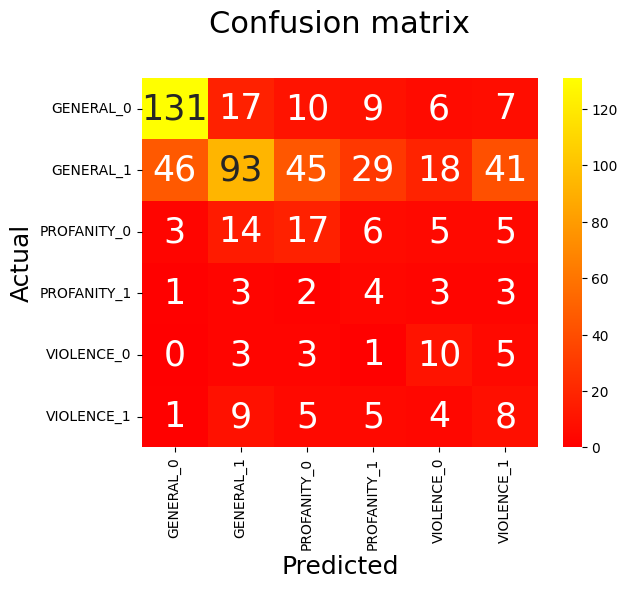

In [21]:
# Training SVC without class_weight

svc2 = SVC(probability=True, random_state=42)
svc2.fit(X_ncr_smote,y_ncr_smote)

# Scores of SVC2
svc2_pred=make_scores(svc2, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc2_pred)

In [22]:
# Let's try PCA too

import pandas as pd
from sklearn.decomposition import PCA

# Define the number of principal components
n_components = 50
pca = PCA(n_components=n_components)

# Apply PCA on the balanced training set 
X_ncr_smote_pca = pca.fit_transform(X_ncr_smote)

# Transform the test sets using the same PCA model
X_test_unbal_pca = pca.transform(X_test_unbal)

# Convert PCA results to DataFrames
X_ncr_smote_pca_df = pd.DataFrame(X_ncr_smote_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_test_unbal_pca_df = pd.DataFrame(X_test_unbal_pca, columns=[f"PC{i+1}" for i in range(n_components)])

Accuracy :0.40035
AUC : 0.74749
Precision : 0.30379
Recall : 0.35522
F1 : 0.29554
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       180
           1       0.61      0.26      0.37       272
           2       0.18      0.26      0.21        50
           3       0.06      0.25      0.10        16
           4       0.22      0.45      0.30        22
           5       0.08      0.22      0.12        32

    accuracy                           0.40       572
   macro avg       0.30      0.36      0.30       572
weighted avg       0.53      0.40      0.43       572



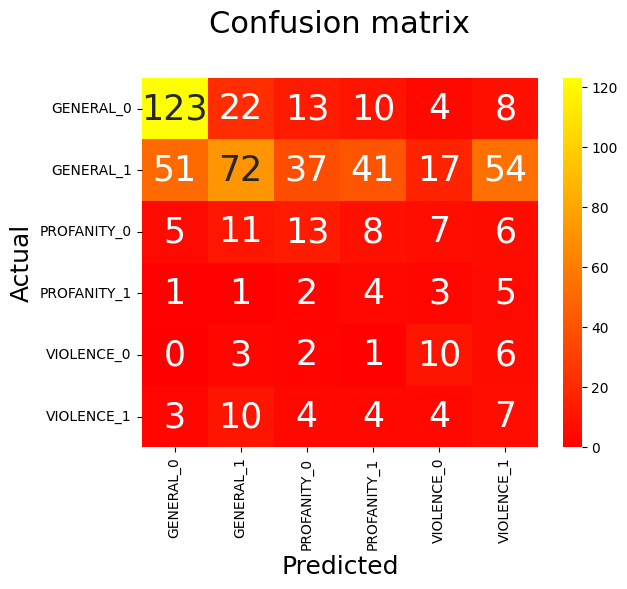

In [23]:
# Training SVC_pca

svc2_pca = SVC(probability=True, random_state=42)
svc2_pca.fit(X_ncr_smote_pca,y_ncr_smote)

# Scores of SVC
svc2_pred=make_scores(svc2_pca, X_test_unbal_pca, y_test_unbal)

# Confusion Matrix for SVC
make_confusion_matrix(y_test_unbal,svc2_pred)

Accuracy :0.38112
AUC : 0.71426
Precision : 0.31750
Recall : 0.34862
F1 : 0.28774
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       180
           1       0.65      0.27      0.38       272
           2       0.18      0.50      0.26        50
           3       0.05      0.25      0.09        16
           4       0.15      0.23      0.18        22
           5       0.12      0.28      0.17        32

    accuracy                           0.38       572
   macro avg       0.32      0.35      0.29       572
weighted avg       0.58      0.38      0.43       572



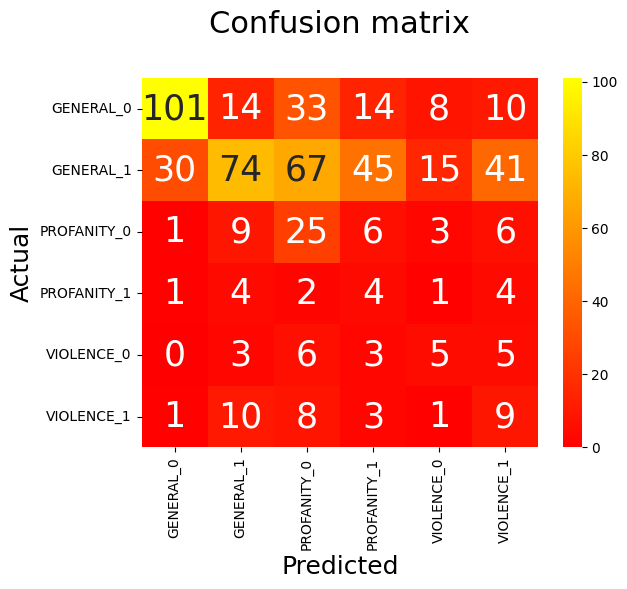

In [24]:
# Tying AdaBoostClassifier

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42) 
ada.fit(X_ncr_smote, y_ncr_smote)

ada_pred= make_scores(ada, X_test_unbal, y_test_unbal)
make_confusion_matrix(y_test_unbal,ada_pred)

## NCR and ADAYSN

In [25]:
y_undersampled.value_counts()

Target
2    200
0    200
1    200
5    127
4     86
3     67
Name: count, dtype: int64

In [26]:
from imblearn.over_sampling import ADASYN

# Define the sampling strategy for SMOTE
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_ncr_adasyn, y_ncr_adasyn = adasyn.fit_resample(X_undersampled, y_undersampled)

y_ncr_adasyn.value_counts()

Target
2    200
0    200
1    200
3    192
5    127
4     86
Name: count, dtype: int64

Accuracy :0.46329
AUC : 0.77602
Precision : 0.38399
Recall : 0.37475
F1 : 0.33632
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       180
           1       0.67      0.36      0.47       272
           2       0.17      0.40      0.24        50
           3       0.09      0.38      0.14        16
           4       0.56      0.23      0.32        22
           5       0.12      0.16      0.14        32

    accuracy                           0.46       572
   macro avg       0.38      0.37      0.34       572
weighted avg       0.59      0.46      0.49       572



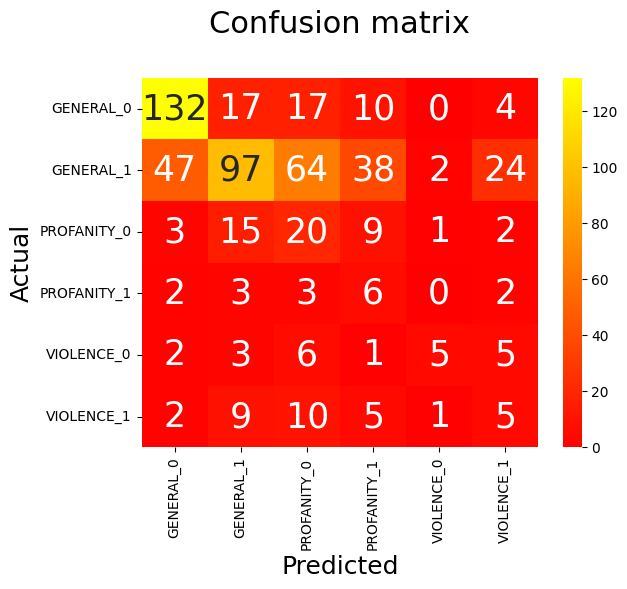

In [27]:
svc3 = SVC(probability=True, random_state=42)
svc3.fit(X_ncr_adasyn,y_ncr_adasyn)

# Scores of SVC2
svc3_pred=make_scores(svc3, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc3_pred)

# CNN undersampling and SMOTE

In [28]:
y_general.value_counts()

Target
1    1086
0     721
Name: count, dtype: int64

In [29]:
# First undersampling GENERAL using CNN
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42)  

# Resampling
X_cnn_undersampled, y_cnn_undersampled= cnn.fit_resample(X_general, y_general)

# Creating a new DataFrame with cleaned 'GENERAL' and 'PROFANITY_0' samples
df_general2 = pd.DataFrame(
    data=X_cnn_undersampled,
    columns=X_general.columns
).assign(Target=y_cnn_undersampled.values)

df_general2 = df_general2.copy() #To avoid fragmentation

# Combining with other classes
df_cnn= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general2])

In [30]:
df_cnn.loc[:,"Target"].value_counts()

Target
0    721
1    492
2    200
5    127
4     86
3     67
Name: count, dtype: int64

In [31]:
# RandomunderSampling

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)  
X_cnn_resampled_rus, y_cnn_resampled_rus = rus.fit_resample(X_cnn_undersampled, y_cnn_undersampled)

# DataFrame for this operation

df_general2 = pd.DataFrame(
    data=X_cnn_resampled_rus,
    columns=X_general.columns
).assign(Target=y_cnn_resampled_rus.values)

df_general2.loc[:,"Target"].value_counts()

Target
0    200
1    200
Name: count, dtype: int64

In [32]:
# Combining with other classes
df_undersampled_cnn= pd.concat([df_train_unbal[df_train_unbal['Target'].isin([2, 3, 4, 5])], df_general2])

df_undersampled_cnn.loc[:,"Target"].value_counts()

Target
2    200
0    200
1    200
5    127
4     86
3     67
Name: count, dtype: int64

In [33]:
# SMOTE

X_cnn_resampled_smote, y_cnn_resampled_smote=df_undersampled_cnn.drop(['Target'], axis=1), df_undersampled_cnn['Target']

# Define the sampling strategy for SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_cnn_smote, y_cnn_smote = smote.fit_resample(X_cnn_resampled_smote, y_cnn_resampled_smote)

y_cnn_smote.value_counts()

Target
3    200
5    200
4    200
2    200
0    200
1    200
Name: count, dtype: int64

Accuracy :0.47727
AUC : 0.77652
Precision : 0.35544
Recall : 0.42421
F1 : 0.35568
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       180
           1       0.72      0.36      0.48       272
           2       0.24      0.42      0.30        50
           3       0.08      0.25      0.12        16
           4       0.23      0.45      0.30        22
           5       0.15      0.34      0.21        32

    accuracy                           0.48       572
   macro avg       0.36      0.42      0.36       572
weighted avg       0.61      0.48      0.51       572



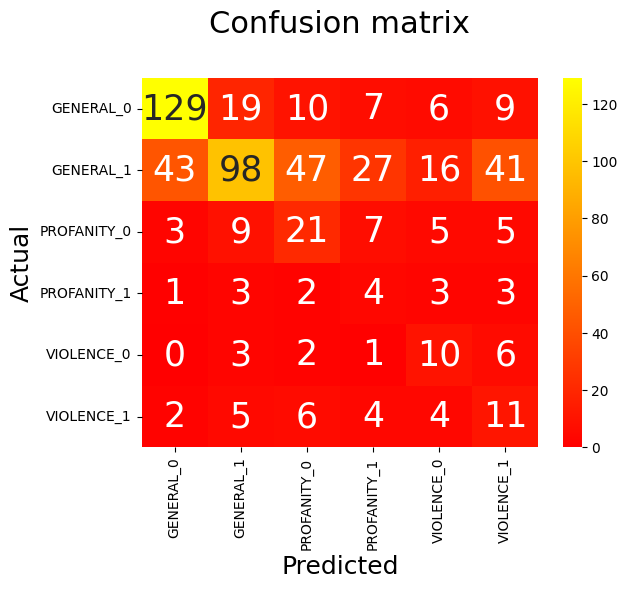

In [34]:
svc4 = SVC(probability=True, random_state=42)
svc4.fit(X_cnn_smote,y_cnn_smote)

# Scores of SVC2
svc4_pred=make_scores(svc4, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc4_pred)

## CNN and ADASYN

In [35]:
X_cnn_resampled_adasyn, y_cnn_resampled_adasyn=df_undersampled_cnn.drop(['Target'], axis=1), df_undersampled_cnn['Target']

# Define the sampling strategy for ADASYN
X_cnn_adasyn, y_cnn_adasyn = adasyn.fit_resample(X_cnn_resampled_adasyn, y_cnn_resampled_adasyn)

y_cnn_adasyn.value_counts()

Target
2    200
0    200
1    200
3    193
5    127
4     86
Name: count, dtype: int64

Accuracy :0.49825
AUC : 0.77479
Precision : 0.38689
Recall : 0.39146
F1 : 0.35436
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       180
           1       0.68      0.43      0.53       272
           2       0.21      0.50      0.29        50
           3       0.09      0.31      0.14        16
           4       0.44      0.18      0.26        22
           5       0.16      0.22      0.18        32

    accuracy                           0.50       572
   macro avg       0.39      0.39      0.35       572
weighted avg       0.60      0.50      0.53       572



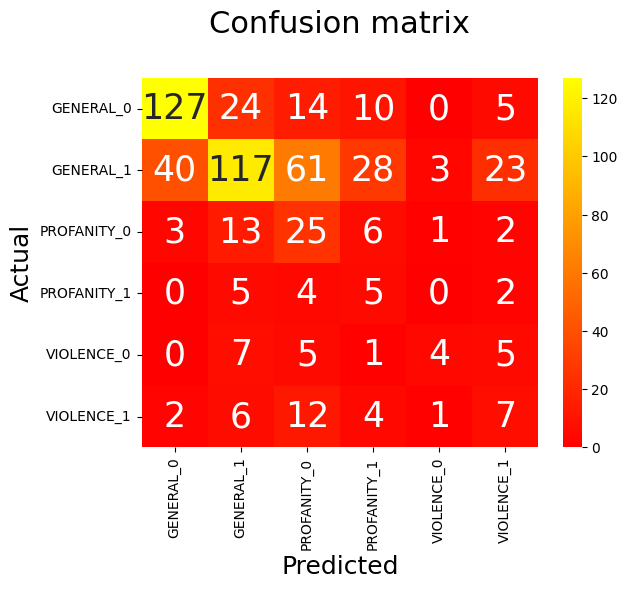

In [36]:
svc5 = SVC(probability=True, random_state=42)
svc5.fit(X_cnn_adasyn,y_cnn_adasyn)

# Scores of SVC2
svc5_pred=make_scores(svc5, X_test_unbal, y_test_unbal)

# Confusion Matrix for SVC2
make_confusion_matrix(y_test_unbal,svc5_pred)

Accuracy :0.44231
AUC : 0.68122
Precision : 0.27752
Recall : 0.29292
F1 : 0.26045
              precision    recall  f1-score   support

           0       0.63      0.75      0.68       180
           1       0.64      0.33      0.44       272
           2       0.16      0.44      0.24        50
           3       0.05      0.12      0.08        16
           4       0.12      0.05      0.07        22
           5       0.06      0.06      0.06        32

    accuracy                           0.44       572
   macro avg       0.28      0.29      0.26       572
weighted avg       0.52      0.44      0.45       572



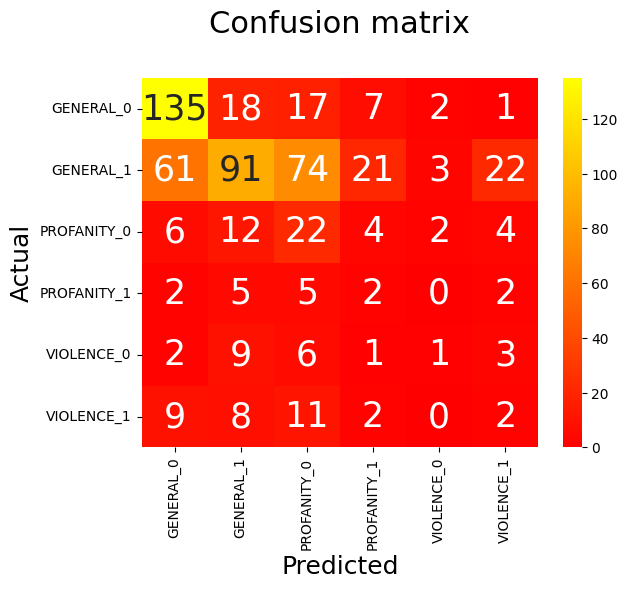

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_cnn_adasyn, y_cnn_adasyn)

# Make predictions
rf_pred = make_scores(rf, X_test_unbal, y_test_unbal)

# Confusion matrix
make_confusion_matrix(y_test_unbal, rf_pred)